# DiploDatos 2020 - Coronavirus en Argentina

El dataset se encuetra en:

https://github.com/lucia15/Datos-Covid19-Argentina

In [1]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Práctico Introducción al Machine Learning

**Consigna:**

Proponer un modelo de Aprendizaje Automático para estos datos. 

Para ello deberan explorar y probar varios modelos, buscando las configuraciones que mejores resultados den. Tener en cuenta:

* Elección de la variable objetivo y features
* Selección de un modelo
* Ajuste de hiperparámetros 
* Evaluación

Veamos unos sencillos (e incompletos) **ejemplos**.

### Carga de datos

In [2]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19.csv'

data = pd.read_csv(url, error_bad_lines=False)

**Variable objetivo: 'casos_nuevos'**

Puesto que muchas de las variables presentes en el dataset son **series temporales**, es importante tener en cuenta que para aplicar modelos de aprendizaje supervisado, es necesario realizar algunas adaptaciones previamente.

El siguiente método se conoce como **sliding window**.

In [4]:
df = pd.DataFrame()

df['t']   = data['casos_nuevos']
df['t+1'] =  df['t'].shift(-1)
df['casos_activos'] = data['casos_total']-data['alta_total']
df['casos_activos+1'] = df['casos_activos'].shift(-1)

df

,t,t+1,casos_activos,casos_activos+1
0,1,1.0,1.0,2.0
1,1,7.0,2.0,9.0
2,7,3.0,9.0,12.0
3,3,5.0,12.0,17.0
4,5,2.0,17.0,19.0
...,...,...,...,...
175,10104,11717.0,100127.0,104789.0
176,11717,9230.0,104789.0,107232.0
177,9230,7187.0,107232.0,107231.0
178,7187,9309.0,107231.0,NaN


Tiramos la última fila que contiene un NaN

In [5]:
df.drop(df.tail(1).index,inplace=True)

In [6]:
df['t'].shape, df['t+1'].shape, df['casos_activos'].shape

((179,), (179,), (179,))

Fuente: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

### División en etrenamiento y evaluación

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X, y = df['t'].to_numpy().reshape(-1,1), df['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((143, 1), (36, 1))

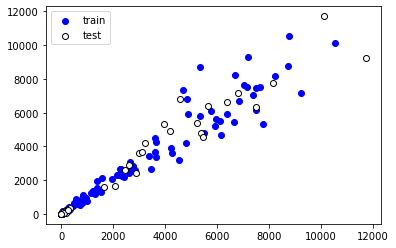

In [9]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.legend()
plt.show()

### Regresión Lineal

Probaremos ajustar los puntos usando una recta.

In [10]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [12]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [13]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.99052329]]
Mean squared error
Train error: 404438.79
Test error: 603599.62
Coefficient of determination
Train: 0.94
Test: 0.94


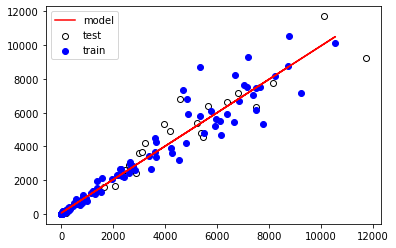

In [14]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

### Regresión casos nuevos versus casos activos

In [15]:
df = df.dropna()

In [16]:
X, y = df['t'].to_numpy().reshape(-1,1), df['casos_activos'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((130, 1), (33, 1))

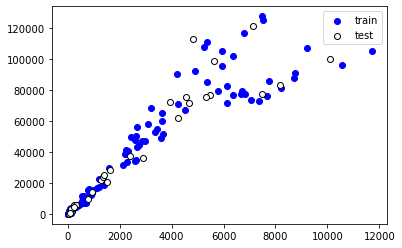

In [17]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.legend()
plt.show()

### Regresión Lineal

Probaremos ajustar los puntos usando una recta.

In [18]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [19]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [20]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[12.28497407]]
Mean squared error
Train error: 155675462.88
Test error: 196857774.46
Coefficient of determination
Train: 0.88
Test: 0.86


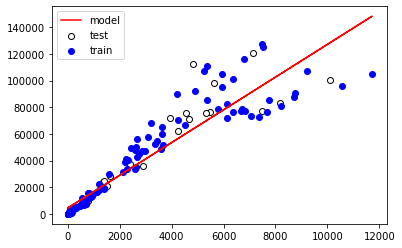

In [21]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

#### Regresión promediando n días

In [22]:
n = 3

casos_t  = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
casos_t1 = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

len(casos_t),len(casos_t1)

(59, 59)

In [23]:
df3 = pd.DataFrame()

n = 3

df3['t']   = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
df3['t+1'] = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

In [24]:
df7 = pd.DataFrame()

n = 7

df7['t']   = [ df['t'][q:q+2].mean() for q in range(0,len(df['t'])-2*n+1,n) ]
df7['t+1'] = [ df['t'][q:q+2].mean() for q in range(n,len(df['t'])-n+1,n)   ]
df7['casos_activos']   = [ df['casos_activos'][q:q+2].mean() for q in range(0,len(df['casos_activos'])-2*n+1,n) ]

In [25]:
df5 = pd.DataFrame()

n = 5

df5['t']   = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
df5['t+1'] = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

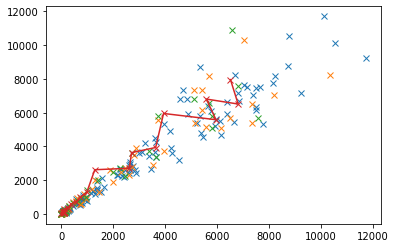

In [26]:
plt.plot(df['t'],df['t+1'],'x')
plt.plot(df3['t'],df3['t+1'],'x')
plt.plot(df5['t'],df5['t+1'],'x')
plt.plot(df7['t'],df7['t+1'],'x-')

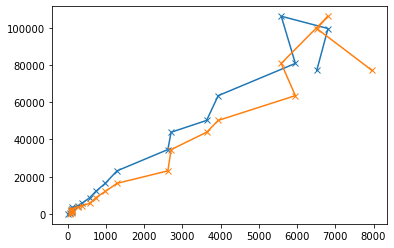

In [27]:
plt.plot(df7['t'],df7['casos_activos'],'x-')
plt.plot(df7['t+1'],df7['casos_activos'],'x-')

##### n = 3

In [58]:
X, y = df3['t'].to_numpy().reshape(-1,1), df3['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((41, 1), (18, 1))

In [59]:
# Create linear regression object
regr3 = linear_model.LinearRegression()

# Train the model using the training sets
regr3.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr3.predict(X_test)

# and training set
y_train_pred = regr3.predict(X_train)

In [60]:
# The coefficients
print('Coefficients: \n', regr3.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.94197394]]
Mean squared error
Train error: 667236.14
Test error: 1010749.55
Coefficient of determination
Train: 0.90
Test: 0.89


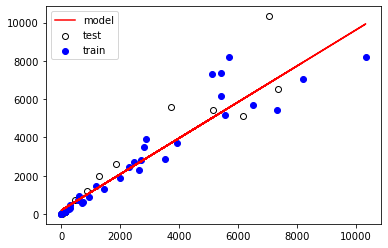

In [61]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

##### n = 5

In [62]:
X, y = df5['t'].to_numpy().reshape(-1,1), df5['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((28, 1), (7, 1))

In [63]:
# Create linear regression object
regr5 = linear_model.LinearRegression()

# Train the model using the training sets
regr5.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr5.predict(X_test)

# and training set
y_train_pred = regr5.predict(X_train)

In [64]:
# The coefficients
print('Coefficients: \n', regr5.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[1.15790885]]
Mean squared error
Train error: 876643.29
Test error: 640110.27
Coefficient of determination
Train: 0.90
Test: 0.85


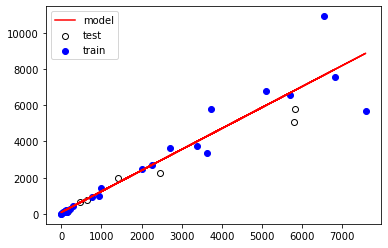

In [65]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

##### n = 7

In [66]:
X, y = df7['t'].to_numpy().reshape(-1,1), df7['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((17, 1), (5, 1))

In [67]:
# Create linear regression object
regr7 = linear_model.LinearRegression()

# Train the model using the training sets
regr7.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr7.predict(X_test)

# and training set
y_train_pred = regr7.predict(X_train)

In [68]:
# The coefficients
print('Coefficients: \n', regr7.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[1.15703456]]
Mean squared error
Train error: 247273.80
Test error: 676205.93
Coefficient of determination
Train: 0.97
Test: 0.86


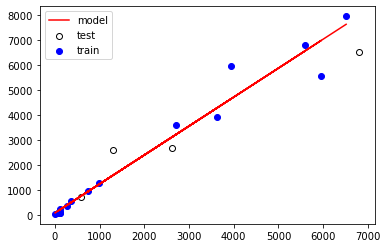

In [69]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

In [70]:
n = 3

casos_t  = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
casos_t1 = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

len(casos_t),len(casos_t1)

(59, 59)

### Casos activos versus casos nuevos

In [76]:
X, y = df7['t'].to_numpy().reshape(-1,1), df7['casos_activos'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((17, 1), (5, 1))

In [77]:
# Create linear regression object
regr7 = linear_model.LinearRegression()

# Train the model using the training sets
regr7.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr7.predict(X_test)

# and training set
y_train_pred = regr7.predict(X_train)

In [78]:
# The coefficients
print('Coefficients: \n', regr7.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[14.42766764]]
Mean squared error
Train error: 60485538.18
Test error: 6952471.15
Coefficient of determination
Train: 0.95
Test: 0.99


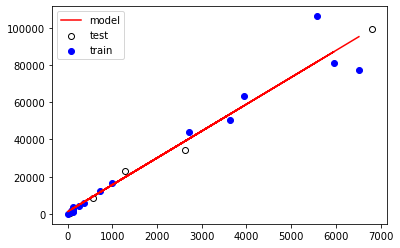

In [79]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

In [80]:
X, y = df7['t+1'].to_numpy().reshape(-1,1), df7['casos_activos'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((17, 1), (5, 1))

In [81]:
# Create linear regression object
regr7 = linear_model.LinearRegression()

# Train the model using the training sets
regr7.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr7.predict(X_test)

# and training set
y_train_pred = regr7.predict(X_train)

In [82]:
# The coefficients
print('Coefficients: \n', regr7.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[12.20364974]]
Mean squared error
Train error: 69701575.64
Test error: 94809677.39
Coefficient of determination
Train: 0.94
Test: 0.92


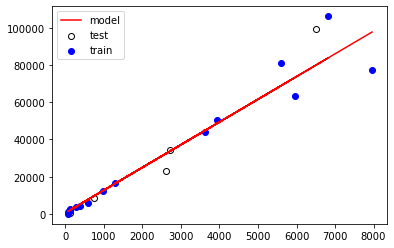

In [83]:
# Plot outputs
plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

### Rt??? casos nuevos / casos activos

In [84]:
df_r = pd.DataFrame()

df_r['t_days']        = [ (pd.to_datetime(fecha) - pd.to_datetime(data['fecha'][0])).days for fecha in data['fecha'] ]
df_r['casos_activos'] = df['casos_activos']
df_r['diff']          = df['casos_activos+1'] - df['casos_activos']
df_r['activos/t']     = df['casos_activos']/df['t']
df_r = df_r.dropna()

In [85]:
def Ones(x):
    return np.ones(len(x))

def times(x):
    return np.arange(1,len(x)+1,1)

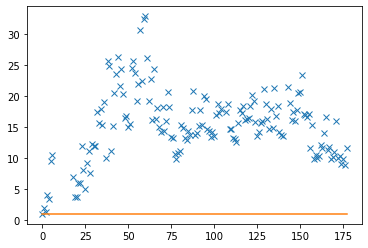

In [86]:
df_r = df_r.dropna()


plt.plot(df_r['t_days'],df_r['activos/t'], 'x')
plt.plot(df_r['t_days'],Ones(df_r['t_days']))

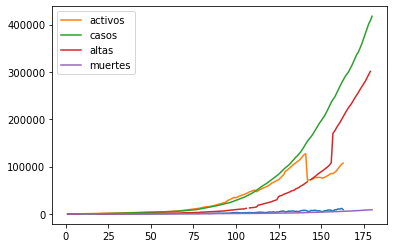

In [87]:
plt.plot(times(df['t']),df['t'])
plt.plot(times(df['casos_activos']),df['casos_activos'], label='activos')
plt.plot(times(data['casos_total']),data['casos_total'],label='casos')
plt.plot(times(data['alta_total']),data['alta_total'],label='altas')
plt.plot(times(data['muertes_total']),data['muertes_total'],label='muertes')
plt.legend()

### Regresión polinomial

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [95]:
df = pd.DataFrame()

df['casos_nuevos']   = data['casos_nuevos']
df['casos_activos']  = data['casos_total']-data['alta_total']
df['t_days']         = [ (pd.to_datetime(fecha) - pd.to_datetime(data['fecha'][0])).days for fecha in data['fecha'] ]
df['tests_nuevos']   = data['tests_realizados_nuevos']
df['tests_total']    = data['tests_realizados_total']
df['muertes_nuevos']    = data['muertes_nuevos']
df = df.dropna()
#df

In [96]:
select = df.keys()
select = select.drop('casos_nuevos')
len(df[select].to_numpy().reshape(-1,1))

720

In [97]:
y, X = df['muertes_nuevos'].to_numpy().reshape(-1,1), df[select].to_numpy().reshape(-1,len(select))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((115, 5), (29, 5), (115, 1), (29, 1))

In [98]:
train_errors = []
test_errors = []
degrees = range(1,10)
print( 'degree', '\t', 'train err', '\t', 'test err' )

for degree in degrees:
    # train:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    print( degree, '\t', train_error.round(2), '\t\t', test_error.round(2) )

degree 	 train err 	 test err
1 	 0.0 		 0.0
2 	 0.0 		 0.0
3 	 0.91 		 42.07
4 	 19.54 		 6934.47
5 	 3.29 		 162644.1
6 	 3.37 		 1145083.59
7 	 12.79 		 121395491.61
8 	 32.11 		 49719027.85
9 	 1359.48 		 44740977.29


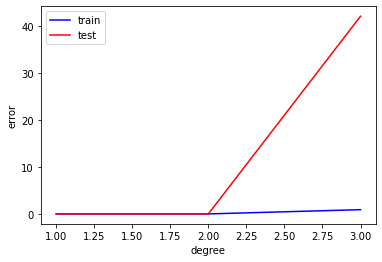

In [99]:
d = 3
plt.plot(degrees[:d], train_errors[:d], color="blue", label="train")
plt.plot(degrees[:d], test_errors[:d], color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

### Clasificación

In [15]:
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19-fallecidos.csv'

data = pd.read_csv(url, error_bad_lines=False)

In [16]:
data = data.drop(columns=['fecha', 'num_caso', 'tipo_caso', 'comorbilidades', 'viajes', 'observaciones'])

data = data.dropna()

data

,provincia,genero,edad
0,CABA,hombre,64.0
1,Chaco,hombre,61.0
2,CABA,hombre,64.0
3,Buenos Aires,mujer,67.0
5,Chaco,hombre,53.0
...,...,...,...
2277,Río Negro,hombre,87.0
2278,Buenos Aires,mujer,74.0
2279,Buenos Aires,mujer,61.0
2280,Buenos Aires,mujer,64.0


Tenemos 17 provincias:

In [17]:
print(data['provincia'].unique())

['CABA' 'Chaco' 'Buenos Aires' 'Tucumán' 'Neuquén' 'La Rioja' 'Córdoba'
 'Santa Fe' 'Mendoza' 'Río Negro' 'Misiones' 'Chubut' 'Jujuy'
 'Tierra del Fuego' 'Salta' 'Entre Ríos' 'Corrientes']


Como se trata de una **variable categórica**, en la cuál no hay una relación de orden entre las categorías, necesitamos aplicar un **One Hot Encoding**

In [18]:
data = pd.concat([data, pd.get_dummies(data['provincia'], prefix='provincia')],axis=1).drop(['provincia'], axis=1)

data

,genero,edad,provincia_Buenos Aires,provincia_CABA,provincia_Chaco,provincia_Chubut,provincia_Corrientes,provincia_Córdoba,provincia_Entre Ríos,provincia_Jujuy,provincia_La Rioja,provincia_Mendoza,provincia_Misiones,provincia_Neuquén,provincia_Río Negro,provincia_Salta,provincia_Santa Fe,provincia_Tierra del Fuego,provincia_Tucumán
0,hombre,64.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,hombre,61.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,hombre,64.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,mujer,67.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,hombre,53.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,hombre,87.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2278,mujer,74.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2279,mujer,61.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2280,mujer,64.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Selección de features y variable objetivo

**variable objetivo: 'genero'**

In [19]:
feature_names = ['provincia_Buenos Aires', 'provincia_CABA', 'provincia_Chaco', 'provincia_Chubut', 'provincia_Corrientes', 'provincia_Córdoba', 'provincia_Entre Ríos', 'provincia_Jujuy', 'provincia_La Rioja', 
                 'provincia_Mendoza', 'provincia_Misiones', 'provincia_Neuquén', 'provincia_Río Negro', 'provincia_Salta', 'provincia_Santa Fe', 'provincia_Tierra del Fuego', 'provincia_Tucumán', 'edad']

X = data[feature_names]
y = data['genero']

In [20]:
X.shape, y.shape

((2254, 18), (2254,))

### División en etrenamiento y evaluación

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1690, 18), (564, 18), (1690,), (564,))

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.63
Accuracy of Logistic regression classifier on test set: 0.64


/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
from sklearn.metrics import classification_report

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      hombre       0.65      0.86      0.74       330
       mujer       0.63      0.34      0.44       234

    accuracy                           0.64       564
   macro avg       0.64      0.60      0.59       564
weighted avg       0.64      0.64      0.61       564

